# Figure 6 – Comparative analysis of prime editing and cDNA screening datasets of TP53 variants reveals novel pathogenic variants in the oligomerization domain
## Figure 6a

Scatter-plot of prime editing Z-score for pegRNAs ≥ 10% editing at Day 34 in the Nutlin-treated condition, and the corresponding cDNA variant Z-score in the p53-WT background in the presence of Nutlin, colored by p53 domain.

Source data for comparison from here: https://www.nature.com/articles/s41588-018-0204-y

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
#import re
import scipy.stats
import regex as re
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
import statannot
plt.rc('font', family='Helvetica')

In [2]:
#loading in info about LFC, correct editing percentage and pegRNAs
#reading the MAGeCK results into a dictionary
#and also reading in information about correct editing percentage

#loading in the data
p53_filtered = pd.read_csv('p53_PE_sensor_FINAL_clean.csv')


#loading in the merged replicates to boost confidence on sensor
fp = "crispresso_replicates_merged"
reorder = []
conditions = ['D4', 'D16', 'D16-NUT', 'D25', 'D25-NUT', 'D34', 'D34-NUT']
for i in conditions:
    df = pd.read_csv(f"{fp}/{i}_reps_combined.csv")
    df['peg_id'] = p53_filtered['peg_id']
    reorder.append(df)

cp_dict2 = dict(zip(conditions, reorder))
samps = list(cp_dict2.keys())[1:]


#reading in mageck
fp = './MAGeCK analysis'
files = os.listdir(fp)
files = sorted([f for f in files if f[-3:]=='txt'])

dfs = []
for i,f in enumerate(files):
    df = pd.read_csv(fp + '/' + f, sep='\t')

    #ensure naming is correct
    assert f[:3]==samps[i][:3]

    #reorder the pegs...
    df = df.rename(columns = {'sgrna':'peg_id'})
    df_merge = pd.merge(p53_filtered, df, how='left', on='peg_id')

    #also add in merge of cp_dict?

    dfs.append(df_merge)


#perform thresholding of control_mean counts (filtering out pegRNAs with below 10 control counts mean)
#differences in counts because of normalization
#going to do it for one and apply it to all...

control_mean_threshold = 10

#d16
dd = dfs[0]
dd = dd[dd['control_mean']>=control_mean_threshold]
pegs_above_thres = dd['peg_id']

dfs2 = []
for i in dfs:
    dfs2.append(i[i['peg_id'].isin(pegs_above_thres)])


assert list(dfs2[0]['peg_id']) == list(dfs2[1]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[2]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[3]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[4]['peg_id']) 
assert list(dfs2[0]['peg_id']) == list(dfs2[5]['peg_id']) 

mageck_dict = dict(zip(samps, dfs2))


In [3]:
sample = 'D34-NUT'
counts_threshold=10 #minimum of 10 sensor counts

bb = mageck_dict[sample].copy()
d34 = cp_dict2[sample]
p = d34[d34['Reads_aligned_all_amplicons']>=counts_threshold]

merged = pd.merge(bb, p, on='peg_id')

#filter to only include SNPs and ONPs
merged = merged[merged['variant_type'].isin(['SNV', 'ONV'])]


b = pd.read_excel('existing_p53_variant_annotations/41588_2018_204_MOESM6_ESM.xlsx', header=1) #z-scores

b = b.rename(columns={'Allele':'HGVSp'})

#and now change the Terminating variants to the correct format
hg = []
for k in list(b['HGVSp']):
    if 'Z' in k:
        k_new = k[:-1] + 'Ter'
    else:
        k_new = k

    hg.append(k_new)

b['HGVSp']=hg

merged2 = pd.merge(merged, b, on='HGVSp').reset_index()



In [4]:
#calculating z-scores for standardization of comparison

avg = np.average(merged2['LFC'])

std = np.std(merged2['LFC'])

z_scores = (merged2['LFC']-avg)/std

merged2['z_scores'] = z_scores
merged2

,index,peg_id,variant_index,HGVSp,HGVSc,gene,chr,start,end,variant_type,...,Signature_27,Signature_28,Signature_29,Signature_30,IARC_Mutation_Counts,GENIE_Mutation_Counts,Phenotypic_Selection_Model,Mutational_Signatures_Model,Combined_Model,z_scores
0,0,peg_2,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-0.799938
1,1,peg_3,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-0.080875
2,2,peg_4,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-1.053764
3,3,peg_5,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-0.983323
4,4,peg_6,0,R175H,c.524G>A,TP53,chr17,7578406,7578406,SNV,...,0.009368,0.002189,0.019684,0.015739,1221,382,12.340574,126.456961,939.020190,-1.203554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13389,13389,peg_20260,874,V97F,c.289G>T,TP53,chr17,7579398,7579398,SNV,...,0.005206,0.001397,0.069982,0.000000,1,0,1.878838,7.423729,3.333116,0.952459
13390,13390,peg_20261,874,V97F,c.289G>T,TP53,chr17,7579398,7579398,SNV,...,0.005206,0.001397,0.069982,0.000000,1,0,1.878838,7.423729,3.333116,1.138072
13391,13391,peg_20262,874,V97F,c.289G>T,TP53,chr17,7579398,7579398,SNV,...,0.005206,0.001397,0.069982,0.000000,1,0,1.878838,7.423729,3.333116,2.004126
13392,13392,peg_20263,874,V97F,c.289G>T,TP53,chr17,7579398,7579398,SNV,...,0.005206,0.001397,0.069982,0.000000,1,0,1.878838,7.423729,3.333116,1.695874


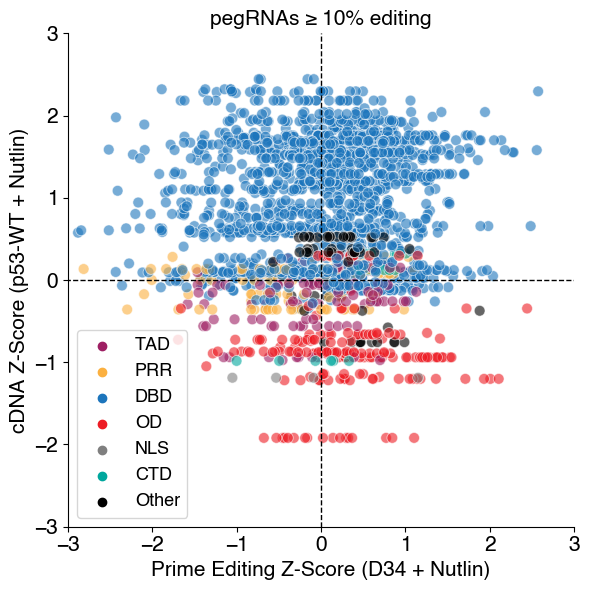

In [5]:
m11 = merged2.copy()
wt_nut = 'A549_p53WT_Nutlin-3_Z-score'

corr_perc_min = 10
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

fig, ax = plt.subplots(figsize=(6,6))

colors= ['#9E1F63', '#FBB040', '#1C75BC', '#ED1C24', 'tab:grey', '#00A79D', 'black']


order = ['TAD', 'PRR', 'DBD', 'OD', 'NLS', 'CTD', 'Other']

sns.scatterplot(data=m11, x='z_scores', y=wt_nut, hue='Domain',ax=ax, palette=colors, hue_order=order, s=60, alpha=.6)#edgecolor='black', linewidth=.2, alpha=.7)
ax.plot([-5,5], [0,0], linestyle='dashed',color='black', linewidth=1)
#ax.plot([0,0], [-2.5,2.5], linestyle='dashed',color='black', linewidth=1)

cutoff = 1.5
x_bins = np.linspace(-5,5,20)
y1 = .5*x_bins-cutoff
y2 = .5*x_bins+cutoff
#ax.plot(x_bins,y1, linestyle='dashed',color='black', linewidth=1)

#ax.plot(x_bins,y2, linestyle='dashed',color='black', linewidth=1)
ax.plot([0,0],[-3, 3],linestyle='dashed',color='black', linewidth=1)


ax.set_ylim(-3,3)
ax.set_xlim(-3,3)


ax.set_xlabel('Prime Editing Z-Score (D34 + Nutlin)', fontsize=15)
ax.set_ylabel('cDNA Z-Score (p53-WT + Nutlin)', fontsize=15)
ax.set_title(f"pegRNAs ≥ {corr_perc_min}% editing", fontsize=15)
#ax.legend(bbox_to_anchor=(1.05, .5), fontsize=14
#          )
ax.legend(fontsize=13, loc='lower left')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

## Figure 6b
cDNA (red) and prime editing (blue) Z-scores for pegRNAs/variants located in the oligomerization domain. The pegRNA with the highest Z-score is labeled.

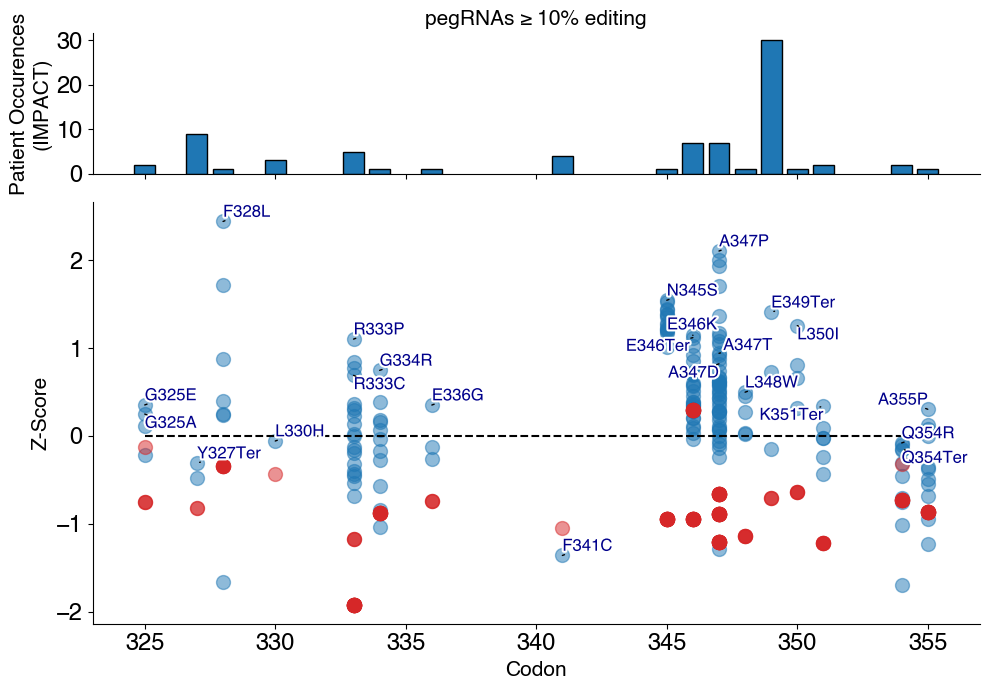

In [6]:
m11 = merged2.copy()

corr_perc_min = 10
corr_perc_max = 100

m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

od = m11.copy()
od = od[od['Domain']=='OD']
od = od.reset_index()

#patient occurrences
uniq_vars, counts = np.unique(od['HGVSp'], return_counts=True)
uniq_vars = list(uniq_vars)

cods = []
noccur = []
for i in uniq_vars:
    sub = m11[m11['HGVSp']==i].reset_index()
    cod = sub.iloc[0]['codon']
    no = sub.iloc[0]['num_occurences']
    cods.append(cod)
    noccur.append(no)

u_cods = list(np.unique(cods))
u_cod_count = np.zeros(len(u_cods))

for i, val in enumerate(cods):
    idx = u_cods.index(val)
    u_cod_count[idx]+=noccur[i]

#-------and plotting----------

fig, ax = plt.subplots(2,1,figsize=(10,7), sharex=True, height_ratios=[1,3])

ax[0].bar(u_cods, u_cod_count, linewidth=1, edgecolor='black')

ax[1].scatter(od['codon'], od['z_scores'], c='tab:blue', alpha=.5, label='Prime Editing', s=100)
ax[1].scatter(od['codon'], od[wt_nut], c='tab:red', alpha=.5, label='cDNA', s=100)

ax[1].plot([325,355], [0,0], linestyle='dashed',color='black' )

ax[1].set_xlim(323,357)

#ax[1].legend(fontsize=15, bbox_to_anchor=(1.05, .75))
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].tick_params(axis='both', which='major', labelsize=17)
ax[1].tick_params(axis='both', which='major', labelsize=17)
ax[1].set_xlabel('Codon', fontsize=15)
ax[0].set_ylabel('Patient Occurences\n(IMPACT)', fontsize=15)
ax[1].set_ylabel('Z-Score', fontsize=15)
ax[0].set_title(f'pegRNAs ≥ {corr_perc_min}% editing', fontsize=15)
#ax[1].legend(bbox_to_anchor=(1.05, .75), fontsize=14
ax[0].set_yticks([0,10,20,30])

uniq_vars, counts = np.unique(od['HGVSp'], return_counts=True)

i_maxs = []
for idx in uniq_vars:
    sub = od[od['HGVSp']==idx]
    i_max = sub['z_scores'].idxmax()
    i_maxs.append(i_max)
    
od_top_vars = od.iloc[i_maxs]
t = list(od_top_vars['HGVSp'])
x=list(od_top_vars['codon'])
y = list(od_top_vars['z_scores'])


texts = [ax[1].text(x[i], y[i], t[i], fontsize=12, color='darkblue', path_effects=[PathEffects.withStroke(linewidth=3,
                                                                                  foreground="w")]) for i in range(len(x))] #bbox = dict(boxstyle = 'round,pad=0.5', fc = 'white', alpha = .9)


adjust_text(texts,only_move={'points':'y', 'texts':'xy'},
            arrowprops=dict(arrowstyle="-", linewidth=1, alpha=1, color='black'))

fig.tight_layout()

## Figure 6c, d

The difference in Z-scores between prime editing and cDNA screens (∆Z-score) for pegRNAs ≥ 10% and ≥ 30% editing, separated by p53 domain. Statistics shown for t-test of independent samples with Bonferroni correction. * = p-value ≤ .05, ** = p-value ≤ .01, *** = p-value ≤ .001, **** = p-value ≤ .0001, ns = not significant (p-value > .05).

In [7]:
#first calcualting the delta z-score
m11 = merged2.copy()
wt_nut = 'A549_p53WT_Nutlin-3_Z-score'
m11['delta'] = m11['LFC'] - m11[wt_nut]

corr_perc_min = 10
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DBD v.s. OD: t-test independent samples with Bonferroni correction, P_val=6.025e-85 stat=-2.071e+01
PRR v.s. OD: t-test independent samples with Bonferroni correction, P_val=1.396e-26 stat=-1.200e+01
TAD v.s. OD: t-test independent samples with Bonferroni correction, P_val=3.684e-15 stat=-8.495e+00


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_26119/456634244.py:9: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)


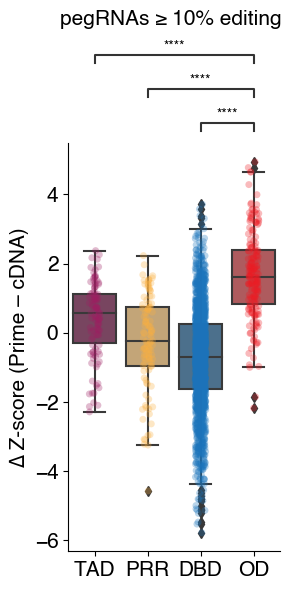

In [8]:
#then plotting 
colors= ['#9E1F63', '#FBB040', '#1C75BC', '#ED1C24']

fig, ax = plt.subplots(figsize=(3,6))

order = ['TAD', 'PRR', 'DBD', 'OD']

sns.boxplot(data=m11, x='Domain', y='delta', order=order,ax=ax, saturation=.4, palette=colors)
sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

import statannot
statannot.add_stat_annotation(
    ax,
    data=m11,
    x='Domain',
    y='delta',
    order=order,
    #hue=hue,
    box_pairs=[
        (("OD"), ("TAD")),
        (("OD"), ("PRR")),
        (("OD"), ("DBD"))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)
ax.set_ylabel('∆ Z-score (Prime – cDNA)', fontsize=15)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(f'pegRNAs ≥ {corr_perc_min}% editing \n\n\n\n\n', fontsize=15)
fig.tight_layout()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

DBD v.s. OD: t-test independent samples with Bonferroni correction, P_val=3.255e-50 stat=-1.610e+01
PRR v.s. OD: t-test independent samples with Bonferroni correction, P_val=3.158e-17 stat=-9.701e+00
TAD v.s. OD: t-test independent samples with Bonferroni correction, P_val=2.085e-11 stat=-7.456e+00


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_22740/2735585198.py:16: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)
/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_22740/2735585198.py:16: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)


Text(0.5, 1.0, 'pegRNAs ≥ 30% editing \n\n\n\n\n\n')

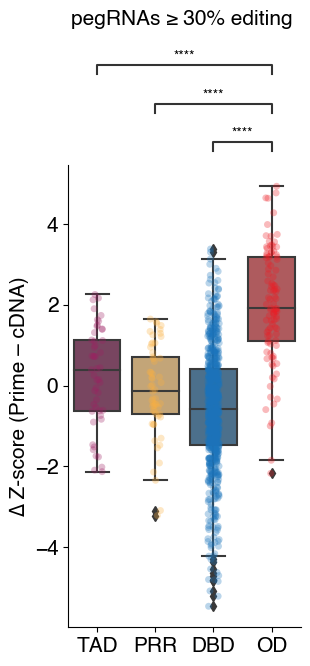

In [19]:
#now redoing for 30% minimum editing
#first calcualting the delta z-score
m11 = merged2.copy()
wt_nut = 'A549_p53WT_Nutlin-3_Z-score'
m11['delta'] = m11['LFC'] - m11[wt_nut]

corr_perc_min = 30
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

fig, ax = plt.subplots(figsize=(3,6))

order = ['TAD', 'PRR', 'DBD', 'OD']

sns.boxplot(data=m11, x='Domain', y='delta', order=order,ax=ax, saturation=.4, palette=colors)
sns.stripplot(data=m11, x='Domain', y='delta', order=order,ax=ax, palette=colors, alpha=.3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

import statannot
statannot.add_stat_annotation(
    ax,
    data=m11,
    x='Domain',
    y='delta',
    order=order,
    #hue=hue,
    box_pairs=[
        (("OD"), ("TAD")),
        (("OD"), ("PRR")),
        (("OD"), ("DBD"))
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)
ax.set_ylabel('∆ Z-score (Prime – cDNA)', fontsize=15)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title(f'pegRNAs ≥ {corr_perc_min}% editing \n\n\n\n\n\n', fontsize=15)


## Figure 6e

Z-scores for variants in the cDNA (red) and prime editing (blue) screens, considering only the most efficient pegRNA for each variant with an editing efficiency ≥ 10%.

In [9]:
#looking at top efficient pegRNAs
uniq_vars, counts = np.unique(od['HGVSp'], return_counts=True)


m11 = merged2.copy()
#m11['delta_'] = m11['LFC'] - m11['A549_p53NULL_Nutlin-3_Z-score']

corr_perc_min = 10
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

od = m11[m11['Domain']=='OD']

od = od.reset_index()

i_maxs = []
for idx in uniq_vars:
    sub = od[od['HGVSp']==idx]
    i_max = sub['corr_perc_backsub'].idxmax()
    i_maxs.append(i_max)
    

od_top_vars = od.iloc[i_maxs]

od2 = od_top_vars.copy()
od2 = od2.drop(columns='z_scores')
od2 = od2.rename(columns={wt_nut:'z_scores'})
od2['Screen']='cDNA'

od_top_vars['Screen'] = 'Prime Editing'

stacked = pd.concat((od_top_vars, od2))

/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_26119/2593632920.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  od_top_vars['Screen'] = 'Prime Editing'


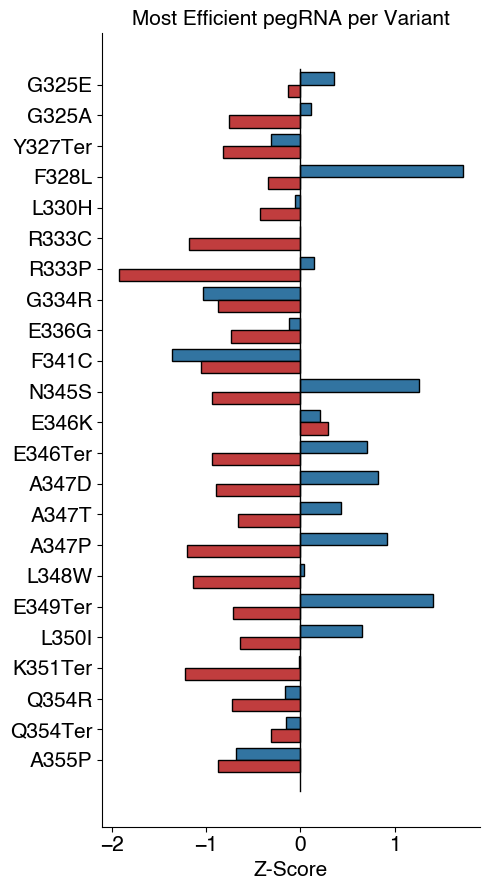

In [10]:
u = np.unique(stacked['HGVSp'])
id = [i[1:4] for i in u]
out = pd.DataFrame(dict(zip(['u','i'], [u,id]))).sort_values(by='i', ascending=True)
order = list(out['u'])

fig, ax = plt.subplots(figsize=(5,9))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)

sns.barplot(data = stacked, y='HGVSp', x='z_scores', hue='Screen', order=order, palette=['tab:blue', 'tab:red'], linewidth=1, edgecolor='black')
ax.plot([0,0],[-.50, len(order)], linewidth=1, color='black')
ax.legend_.remove()

ax.set_ylabel('')
ax.set_xlabel('Z-Score', fontsize=15)
ax.set_title('Most Efficient pegRNA per Variant', fontsize=15)

plt.xticks(rotation=0)

fig.tight_layout()

## Figure 6f

Box-plot of the z-scores for variants in the cDNA (red) and prime editing (blue) screens, considering only the most efficient pegRNA for each variant. Statistics shown for t-test of independent samples with Bonferroni correction; **** = p-value ≤ .0001.

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Prime Editing v.s. cDNA: t-test independent samples with Bonferroni correction, P_val=1.192e-06 stat=5.626e+00


/var/folders/5g/xxjcy2g531n02hnyb6d8qdsr0000gn/T/ipykernel_26119/3918178740.py:10: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data = stacked, x='Screen', y='z_scores', palette=['tab:blue', 'tab:red'], alpha=.5)


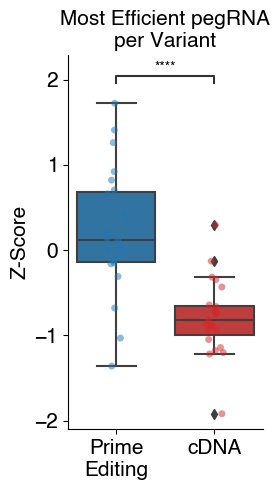

In [11]:
#and a box plot comparison

fig, ax = plt.subplots(figsize=(3,5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=15)

sns.boxplot(data = stacked, x='Screen', y='z_scores', palette=['tab:blue', 'tab:red'])
sns.stripplot(data = stacked, x='Screen', y='z_scores', palette=['tab:blue', 'tab:red'], alpha=.5)

ax.set_xticklabels(['Prime\nEditing', 'cDNA'])
ax.set_xlabel('')
ax.set_ylabel('Z-Score', fontsize=15)
ax.set_title('Most Efficient pegRNA\nper Variant', fontsize=15)

import statannot
statannot.add_stat_annotation(
    ax,
    data=stacked,
    x='Screen',
    y='z_scores',
    #hue=hue,
    box_pairs=[
        (("Prime Editing"), ("cDNA")),
    ],
    test="t-test_ind",
    text_format="star",
    loc="inside",
)

fig.tight_layout()

## Figure 6g

Visualization of the residue-averaged ∆Z-scores (pegRNAs ≥ 10% editing) on an NMR-structure of p53 oligomerization domain (PDB: 1OLG).

Code here shown for generating residue-averaged ∆Z-Scores. Visualization performed in pymol by substituting the b-factors with these values and then visualizing as heatmap. For more info see: https://pymolwiki.org/index.php/Load_new_B-factors


In [25]:
m11 = merged2.copy()
m11['delta'] = m11['LFC'] - m11['A549_p53WT_Nutlin-3_Z-score']

corr_perc_min = 10
corr_perc_max = 100
m11 = m11[(m11['corr_perc_backsub']>=corr_perc_min) & (m11['corr_perc_backsub']<=corr_perc_max)]

sort1 = m11[(m11['codon']>=319) &(m11['codon']<=360)].sort_values(by='codon').reset_index()

codon_locs = list(range(319,361))
holder = np.zeros(len(codon_locs))
delta_df = pd.DataFrame((dict(zip(['codon', 'average_delta'], [codon_locs, holder])))).set_index('codon')

#exclude terminating variants????

#average on codon
for i in np.unique(sort1['codon']):
    sub = sort1[sort1['codon']==i]
    avg1 = np.average(sub['delta'])

    delta_df.loc[int(i), 'average_delta'] = avg1

In [26]:
delta_df

,average_delta
codon,
319,0.000000
320,0.000000
321,0.000000
322,1.814672
323,0.000000
324,2.132768
325,1.046287
326,0.000000
327,0.398751
